In [17]:
%run preamble.py

<Figure size 1152x432 with 0 Axes>

## Week-long CVX Bear Call Strategy with Daily Hedging

**Amount Invested:** $\$646.00$

## 08/21/2023

#### 0) Asset Price: 159.90

#### 1) Bought Call:

- Strike: 167.5
- Ask: $0.21
- Number: 100
- Expiration: 08/25/2023

#### 2) Sold Call:

- Strike: 155
- Bid: $6.25
- Number: 100
- Expiration: 08/25/2023



In [2]:
ticker = 'CVX'
start = dt.datetime.today() - dt.timedelta(days = 7)
end = dt.datetime.today() - dt.timedelta(days = 1)
stock_data = yf.download(ticker,start,end)
stock_data_30 = yf.download(ticker, start = dt.datetime.today() - dt.timedelta(days = 60), end = end -dt.timedelta(days = 8), interval = '30m')
returns = stock_data_30.Close.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Test GARCH(1,1) volatility predictions over a testing period and compare performance to 30-day rolling average volatility.

In [3]:
#GARCH volatility predictions accuracy vs 30-day rolling average

# Split Data into Training and Testing Sets
testing_set = returns.iloc[-60:]
training_set = returns.iloc[:-60]

#Calculate 30-Day Moving Average on the Testing Set
moving_average_30d_full = returns.rolling(window=10).std().dropna()
moving_average_30d = moving_average_30d_full[-60:] #95% volatility cofidence

# Step 4: Perform GARCH Modeling on the Training Set
# Rescale the data (multiply by 100)
training_set_scaled = training_set * 100

# Fit the GARCH(1,1) model to the rescaled training set
garch_model = arch_model(training_set_scaled, vol='Garch', p=4, q=4)
results = garch_model.fit(disp='off')

# Step 5: Calculate GARCH volatility for the testing set
garch_volatility_rescaled = results.conditional_volatility[-60:]/(100)

mse_GARCH = np.mean((np.array(garch_volatility_rescaled.values) - np.array(moving_average_30d.values))**2)


average_moving_average = np.mean(np.array(moving_average_30d.values))
mse_ma = np.mean((np.array(moving_average_30d.values) - average_moving_average)**2)

print(f'The mse of GARCH volatility predicitions: {mse_GARCH}')
print(f"The mse of rolling average volatilitiy predictions: {mse_ma}")

The mse of GARCH volatility predicitions: 1.7792994804467149e-06
The mse of rolling average volatilitiy predictions: 1.561027656922364e-06


## Volatility Model Comparison

Mean Squared Error (MSE) results for different volatility prediction methods:

- MSE of GARCH Volatility Predictions: 1.6456206436660379e-06
- MSE of Rolling Average Volatility Predictions:1.561027656922364e-06

### Conclusion

A smaller MSE indicates better accuracy as it means predicted values are closer to actual values. The MSE of the rolling average volatility is slightly smaller than the rolling average volatility. As the difference is relatively small though, we elect to use GARCH(1,1) to predict volatility as it will adjust volatility computations if there is a large change in prices.

In [16]:
#Monte Carlo simulation of expected profit 08/21/2023
S0 = 159.90
T = 5/252
steps = 5
DT = T / steps
TTE = [T - DT * i for i in range(0, steps + 1)]
r = 0
N = 1000000
forecast = results.forecast(horizon = 13*5, reindex = True)
#sigma = forecast.variance.iloc[-1][-1]
K0 = 167.5
K1 = 155
iv1 = iv(.21, S0, K0, T, 0, 'c')
iv2 = iv(6.25, S0, K1, T, 0, 'c')
sigma = (iv1+iv2)/2

stock_paths = geo_paths(S0, T, sigma, steps, N)
avg_stock_values = [np.mean(stock_paths[i]) for i in range(len(stock_paths))]
call_bought_values = np.maximum(stock_paths[-1]-K0, 0)
call_sold_values = np.maximum(stock_paths[-1] - K1, 0)

number_bought = 100
number_sold = 100
call_bought_premium = .21
call_sold_premium = 6.25


deltas_bought = [MC_delta(avg_stock_values[i], TTE[i], sigma, 10000, K0, 1, 0) for i in range(len(stock_paths))]
call_deltas_bought = [deltas_bought[i]['delta_call'] for i in range(len(stock_paths))]

deltas_sold = [MC_delta(avg_stock_values[i], TTE[i], sigma, 10000, K1, 1, 0) for i in range(len(stock_paths))]
call_deltas_sold = [deltas_sold[i]['delta_call'] for i in range(len(stock_paths))]

X_call_bought = [-call_deltas_bought[i] * ((stock_paths[i + 1] - stock_paths[i])) for i in range(steps)]
X_call_sold = [-call_deltas_sold[i] * ((stock_paths[i + 1] - stock_paths[i])) for i in range(steps)]

call_hedge_bought = np.sum(X_call_bought, axis=0)
call_hedge_sold = np.sum(X_call_sold, axis=0)

hedge_call_bought_values = call_bought_values + call_hedge_bought
hedge_call_sold_values = call_sold_values + call_hedge_sold

position_values = (number_bought*hedge_call_bought_values-number_sold*hedge_call_sold_values)
expected_profit = np.mean(position_values) - number_bought*.21 + number_sold*6.25
stand_err = standard_error(position_values, T)
profit_chance = per_in_money_paths(position_values- number_bought*.21 + number_sold*6.25)



print(f'Expected profit 08/21/2023: {expected_profit}')
print(f'Standard Error 08/21/2023: {stand_err}')
print(f'Chance of profit 08/21/2023: {profit_chance*100}%')


Expected profit 08/21/2023: 71.94410497053809
Standard Error 08/21/2023: 0.1943634064640344
Chance of profit 08/21/2023: 72.024%


### Remark


There is a large chance of profit, but the position requries purchasing and selling a total of 200 contracts. Therefore any profit will likely be eaten away at by trading fees and interest from borrowing capital or stock. This is not a feasible position to take.

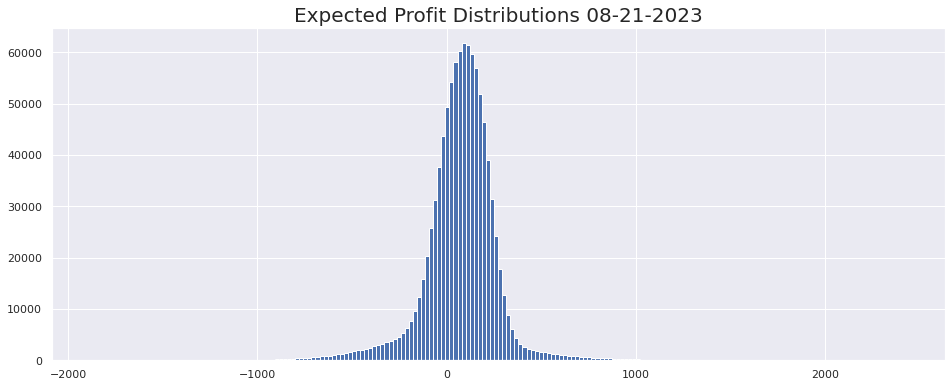

In [5]:
plt.hist(position_values- number_bought*.21 + number_sold*6.25, bins = 200)
plt.title('Expected Profit Distributions 08-21-2023', size = 20)
plt.show()

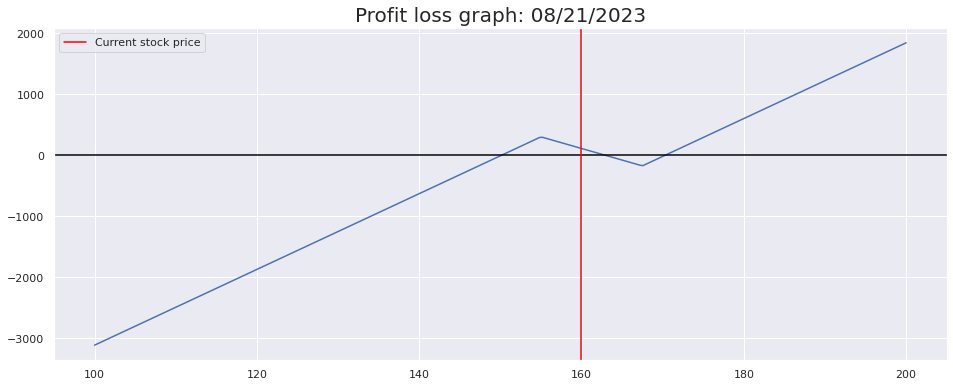

In [6]:
strike_prices = np.linspace(100, 200, 300)

call_bought = np.maximum(strike_prices - K0, 0)

position_delta0 = int(number_bought*MC_delta(S0, T, sigma, 10000, K0, epsilon=1)['delta_call'] - number_sold*MC_delta(S0, T, sigma, 10000, K1, epsilon=1)['delta_call'])

call_sold = np.maximum(strike_prices - K1, 0)

hedge = position_delta0*(strike_prices - S0)

profits = number_bought*(call_bought - call_bought_premium) -number_sold*(call_sold - call_sold_premium) - hedge

plt.plot(strike_prices, profits)
plt.axhline(y=0, color='black')
plt.axvline(x = S0, color = 'red', label = 'Current stock price')
plt.legend()
plt.title('Profit loss graph: 08/21/2023', size = 20)
plt.show()

In [7]:
#Monte Carlo simulation of expected profit 08/22/2023
S1 = stock_data.Close.iloc[0]
T = 4/252
steps = 4
DT = T / steps
TTE = [T - DT * i for i in range(0, steps + 1)]
r = 0
N = 1000000
forecast = results.forecast(horizon = 13*5, reindex = True)
#sigma = forecast.variance.iloc[-1][-1]
K0 = 167.5
K1 = 155

stock_paths = geo_paths(S1, T, sigma, steps, N)
avg_stock_values = [np.mean(stock_paths[i]) for i in range(len(stock_paths))]
call_bought_values = np.maximum(stock_paths[-1]-K0, 0)
call_sold_values = np.maximum(stock_paths[-1] - K1, 0)

number_bought = 100
number_sold = 100
call_bought_premium = .21
call_sold_premium = 6.25


deltas_bought = [MC_delta(avg_stock_values[i], TTE[i], sigma, 10000, K0, 1, 0) for i in range(len(stock_paths))]
call_deltas_bought = [deltas_bought[i]['delta_call'] for i in range(len(stock_paths))]

deltas_sold = [MC_delta(avg_stock_values[i], TTE[i], sigma, 10000, K1, 1, 0) for i in range(len(stock_paths))]
call_deltas_sold = [deltas_sold[i]['delta_call'] for i in range(len(stock_paths))]

X_call_bought = [-call_deltas_bought[i] * ((stock_paths[i + 1] - stock_paths[i])) for i in range(steps)]
X_call_sold = [-call_deltas_sold[i] * ((stock_paths[i + 1] - stock_paths[i])) for i in range(steps)]

call_hedge_bought = np.sum(X_call_bought, axis=0)
call_hedge_sold = np.sum(X_call_sold, axis=0)

hedge_call_bought_values = call_bought_values + call_hedge_bought
hedge_call_sold_values = call_sold_values + call_hedge_sold
hedging_value = - position_delta0*(stock_paths[-1]-S0)


position_values = (number_bought*hedge_call_bought_values-number_sold*hedge_call_sold_values) +hedging_value
expected_profit = np.mean(position_values) - number_bought*.21 + number_sold*6.25
stand_err = standard_error(position_values, T)
profit_chance = per_in_money_paths(position_values- number_bought*.21 + number_sold*6.25)



print(f'Expected profit 08/22/2023: {expected_profit}')
print(f'Standard Error 08/22/2023: {stand_err}')
print(f'Chance of profit 08/22/2023: {profit_chance*100}%')


Expected profit 08/22/2023: 81.27957960144738
Standard Error 08/22/2023: 0.46550981737151204
Chance of profit 08/22/2023: 69.8009%


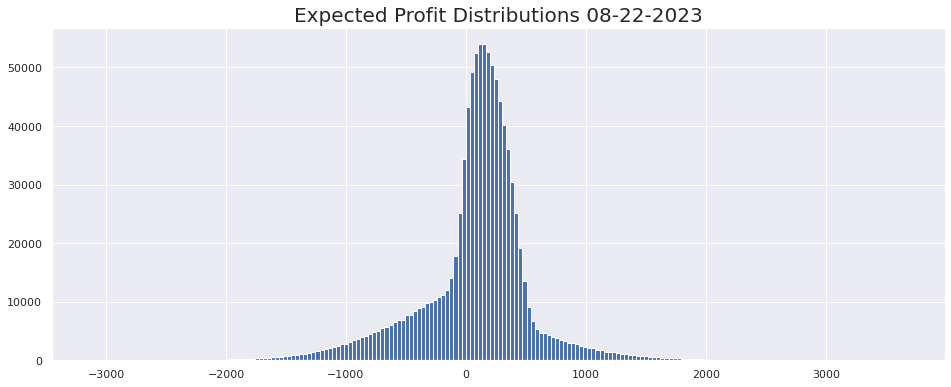

In [8]:
plt.hist(position_values- number_bought*.21 + number_sold*6.25, bins = 200)
plt.title('Expected Profit Distributions 08-22-2023', size = 20)
plt.show()

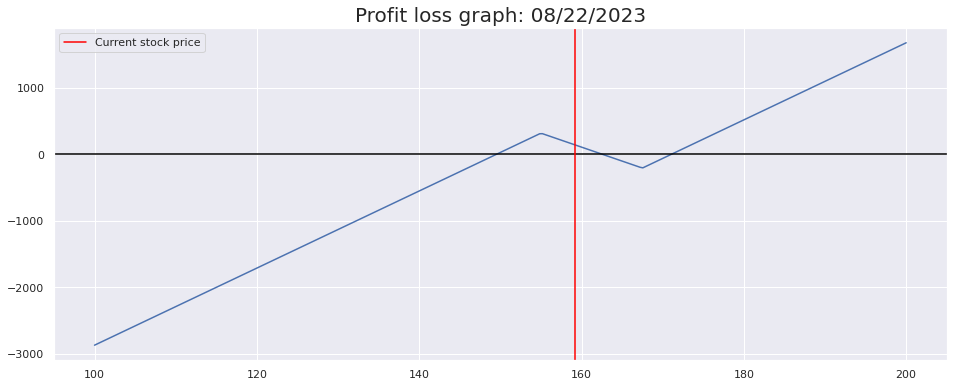

In [9]:
strike_prices = np.linspace(100, 200, 300)

call_bought = np.maximum(strike_prices - K0, 0)

position_delta1 = int(number_bought*MC_delta(S1, T, sigma, 10000, K0, epsilon=1)['delta_call'] - number_sold*MC_delta(S1, T, sigma, 10000, K1, epsilon=1)['delta_call'])

call_sold = np.maximum(strike_prices - K1, 0)

hedge -= (position_delta1-position_delta0)*(strike_prices - S1)

profits = number_bought*(call_bought - call_bought_premium) -number_sold*(call_sold - call_sold_premium) - hedge
plt.plot(strike_prices, profits)
plt.axhline(y=0, color='black')
plt.axvline(x = S1, color = 'red', label = 'Current stock price')
plt.legend()
plt.title('Profit loss graph: 08/22/2023', size = 20)
plt.show()

In [10]:
#Monte Carlo simulation of expected profit 08/23/2023
S2 = stock_data.Close.iloc[1]
T = 3/252
steps = 3
DT = T / steps
TTE = [T - DT * i for i in range(0, steps + 1)]
r = 0
N = 1000000
forecast = results.forecast(horizon = 13*5, reindex = True)
#sigma = forecast.variance.iloc[-1][-1]
K0 = 167.5
K1 = 155

stock_paths = geo_paths(S2, T, sigma, steps, N)
avg_stock_values = [np.mean(stock_paths[i]) for i in range(len(stock_paths))]
call_bought_values = np.maximum(stock_paths[-1]-K0, 0)
call_sold_values = np.maximum(stock_paths[-1] - K1, 0)

number_bought = 100
number_sold = 100
call_bought_premium = .21
call_sold_premium = 6.25


deltas_bought = [MC_delta(avg_stock_values[i], TTE[i], sigma, 10000, K0, 1, 0) for i in range(len(stock_paths))]
call_deltas_bought = [deltas_bought[i]['delta_call'] for i in range(len(stock_paths))]

deltas_sold = [MC_delta(avg_stock_values[i], TTE[i], sigma, 10000, K1, 1, 0) for i in range(len(stock_paths))]
call_deltas_sold = [deltas_sold[i]['delta_call'] for i in range(len(stock_paths))]

X_call_bought = [-call_deltas_bought[i] * ((stock_paths[i + 1] - stock_paths[i])) for i in range(steps)]
X_call_sold = [-call_deltas_sold[i] * ((stock_paths[i + 1] - stock_paths[i])) for i in range(steps)]

call_hedge_bought = np.sum(X_call_bought, axis=0)
call_hedge_sold = np.sum(X_call_sold, axis=0)

hedge_call_bought_values = call_bought_values + call_hedge_bought
hedge_call_sold_values = call_sold_values + call_hedge_sold

hedging_value = - position_delta0*(stock_paths[-1]-S0)
hedging_value += -(position_delta1-position_delta0)*(stock_paths[-1]-S1)

position_values = (number_bought*hedge_call_bought_values-number_sold*hedge_call_sold_values) + hedging_value
expected_profit = np.mean(position_values) - number_bought*.21 + number_sold*6.25
stand_err = standard_error(position_values, T)
profit_chance = per_in_money_paths(position_values- number_bought*.21 + number_sold*6.25)



print(f'Expected profit 08/23/2023: {expected_profit}')
print(f'Standard Error 08/23/2023: {stand_err}')
print(f'Chance of profit 08/23/2023: {profit_chance*100}%')


Expected profit 08/23/2023: 100.38988548137854
Standard Error 08/23/2023: 0.4019886933761438
Chance of profit 08/23/2023: 73.78710000000001%


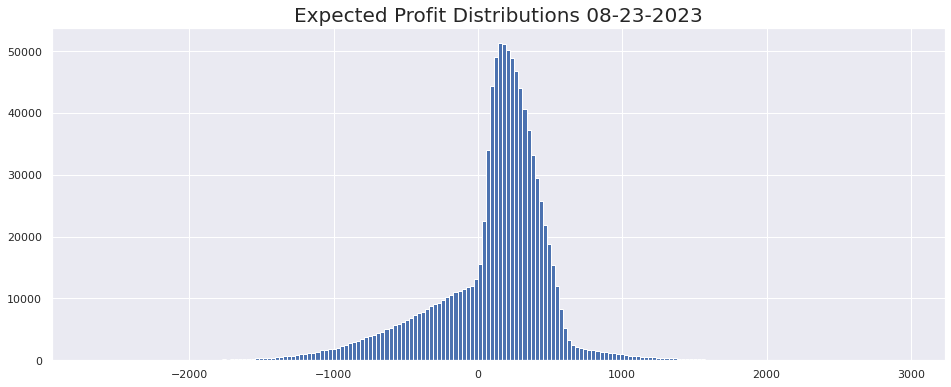

In [11]:
plt.hist(position_values- number_bought*.21 + number_sold*6.25, bins = 200)
plt.title('Expected Profit Distributions 08-23-2023', size = 20)
plt.show()

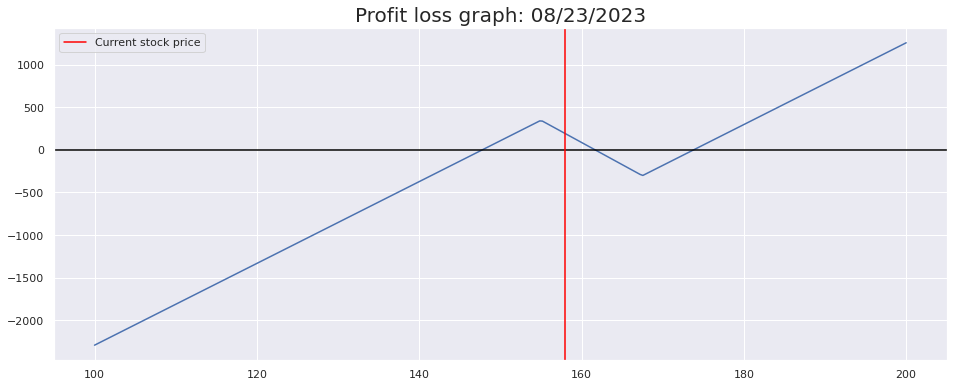

In [12]:
strike_prices = np.linspace(100, 200, 300)

call_bought = np.maximum(strike_prices - K0, 0)

position_delta2 = int(number_bought*MC_delta(S2, T, sigma, 10000, K0, epsilon=1)['delta_call'] - number_sold*MC_delta(S1, T, sigma, 10000, K1, epsilon=1)['delta_call'])

call_sold = np.maximum(strike_prices - K1, 0)

hedge -= (position_delta2-position_delta1)*(strike_prices - S2)

profits = number_bought*(call_bought - call_bought_premium) -number_sold*(call_sold - call_sold_premium) - hedge
plt.plot(strike_prices, profits)
plt.axhline(y=0, color='black')
plt.axvline(x = S2, color = 'red', label = 'Current stock price')
plt.legend()
plt.title('Profit loss graph: 08/23/2023', size = 20)
plt.show()

In [13]:
#Monte Carlo simulation of expected profit 08/23/2023
S3 = stock_data.Close.iloc[2]
T = 2/252
steps = 2
DT = T / steps
TTE = [T - DT * i for i in range(0, steps + 1)]
r = 0
N = 1000000
#sigma = forecast.variance.iloc[-1][-1]
K0 = 167.5
K1 = 155

stock_paths = geo_paths(S3, T, sigma, steps, N)
avg_stock_values = [np.mean(stock_paths[i]) for i in range(len(stock_paths))]
call_bought_values = np.maximum(stock_paths[-1]-K0, 0)
call_sold_values = np.maximum(stock_paths[-1] - K1, 0)

number_bought = 100
number_sold = 100
call_bought_premium = .21
call_sold_premium = 6.25


deltas_bought = [MC_delta(avg_stock_values[i], TTE[i], sigma, 10000, K0, 1, 0) for i in range(len(stock_paths))]
call_deltas_bought = [deltas_bought[i]['delta_call'] for i in range(len(stock_paths))]

deltas_sold = [MC_delta(avg_stock_values[i], TTE[i], sigma, 10000, K1, 1, 0) for i in range(len(stock_paths))]
call_deltas_sold = [deltas_sold[i]['delta_call'] for i in range(len(stock_paths))]

X_call_bought = [-call_deltas_bought[i] * ((stock_paths[i + 1] - stock_paths[i])) for i in range(steps)]
X_call_sold = [-call_deltas_sold[i] * ((stock_paths[i + 1] - stock_paths[i])) for i in range(steps)]

call_hedge_bought = np.sum(X_call_bought, axis=0)
call_hedge_sold = np.sum(X_call_sold, axis=0)

hedge_call_bought_values = call_bought_values + call_hedge_bought
hedge_call_sold_values = call_sold_values + call_hedge_sold

hedging_value = - position_delta0*(stock_paths[-1]-S0)
hedging_value += -(position_delta1-position_delta0)*(stock_paths[-1]-S1)
hedging_value += -(position_delta2-position_delta1)*(stock_paths[-1]-S2)


position_values = (number_bought*hedge_call_bought_values-number_sold*hedge_call_sold_values) + hedging_value
expected_profit = np.mean(position_values) - number_bought*.21 + number_sold*6.25
stand_err = standard_error(position_values, T)
profit_chance = per_in_money_paths(position_values- number_bought*.21 + number_sold*6.25)



print(f'Expected profit 08/24/2023: {expected_profit}')
print(f'Standard Error 08/24/2023: {stand_err}')
print(f'Chance of profit 08/24/2023: {profit_chance*100}%')


Expected profit 08/24/2023: 123.27272347413805
Standard Error 08/24/2023: 0.3533892316294777
Chance of profit 08/24/2023: 72.0261%


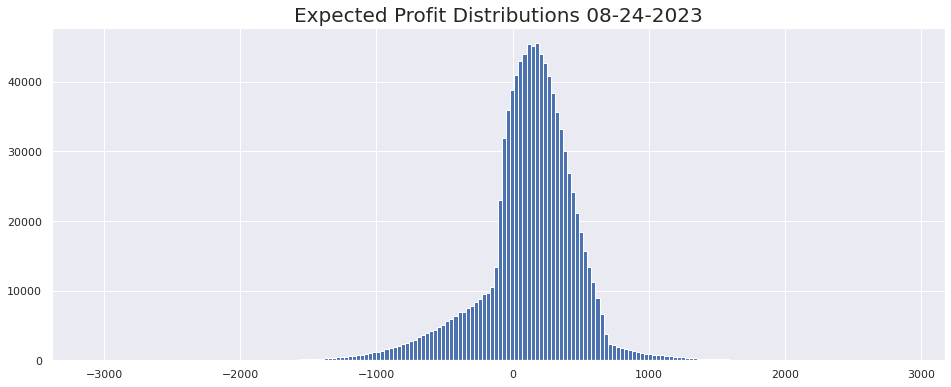

In [14]:
plt.hist(position_values- number_bought*.21 + number_sold*6.25, bins = 200)
plt.title('Expected Profit Distributions 08-24-2023', size = 20)
plt.show()

In [15]:
position_delta3 = int(number_bought*MC_delta(S3, T, sigma, 10000, K0, epsilon=1)['delta_call'] - number_sold*MC_delta(S2, T, sigma, 10000, K1, epsilon=1)['delta_call'])


S4 = stock_data.Close.iloc[3]
hedging_value = -position_delta0 * (S4-S0)
hedging_value += -(position_delta1-position_delta0)*(S4-S1)
hedging_value += -(position_delta2-position_delta1)*(S4-S2)
hedging_value += -(position_delta3-position_delta2)*(S4-S3)
end_position_value = number_bought*(np.maximum(S4-K0,0)-.21)-number_sold*(np.maximum(S4-K1,0) -6.25) + hedging_value


print(f'Final Profit: {end_position_value}')

Final Profit: 125.48977966308559


**Fees and Interest Rates**

Stock/ETF fees 
1) 0.000008*(Total dollar Trade Amount) (Min 0.01) SEC
2) 0.000145 * (Total Trade Volume) (Min 0.01 per stock) - (Max 7.27 per stock) FINRA

Option Fees
1) 0.000008*(Total Trade Amount) (Min \$0.01) SEC Sells only
2) 0.00244 *( No. of Contracts) (Min \$0.01) FINRA Sells only
3) 0.03005 * (No. of Contracts) Option Exchange Buys and Sells
4) 0.02 * (No. of Contracts) (Max $55 per Trade) OCC Buys and Sells

Borrowing Stock Fees:
1) $8$% annual interest